In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings            
warnings.filterwarnings("ignore")

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
# Load the dataset
df = pd.read_csv("imdb_movie_dataset.csv")

In [4]:
df.head()

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40.0


In [5]:
df.shape

(1000, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rank                1000 non-null   int64  
 1   Title               1000 non-null   object 
 2   Genre               1000 non-null   object 
 3   Description         1000 non-null   object 
 4   Director            1000 non-null   object 
 5   Actors              1000 non-null   object 
 6   Year                1000 non-null   int64  
 7   Runtime (Minutes)   1000 non-null   int64  
 8   Rating              1000 non-null   float64
 9   Votes               1000 non-null   int64  
 10  Revenue (Millions)  872 non-null    float64
 11  Metascore           936 non-null    float64
dtypes: float64(3), int64(4), object(5)
memory usage: 93.9+ KB


In [7]:
df.isnull().sum()

Rank                    0
Title                   0
Genre                   0
Description             0
Director                0
Actors                  0
Year                    0
Runtime (Minutes)       0
Rating                  0
Votes                   0
Revenue (Millions)    128
Metascore              64
dtype: int64

In [8]:
# Define the imputer to fill missing values with the mean
imputer = SimpleImputer(strategy='mean')

In [9]:
# Select only the columns that need imputation
columns_to_impute = ['Revenue (Millions)', 'Metascore']

In [10]:
# Apply the imputer to those columns
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

In [11]:
df.isnull().sum()

Rank                  0
Title                 0
Genre                 0
Description           0
Director              0
Actors                0
Year                  0
Runtime (Minutes)     0
Rating                0
Votes                 0
Revenue (Millions)    0
Metascore             0
dtype: int64

In [12]:
df.duplicated().sum()

0

In [13]:
df['Revenue (Millions)'] = np.log1p(df['Revenue (Millions)'])

In [14]:
Q1 = df['Revenue (Millions)'].quantile(0.25)
Q3 = df['Revenue (Millions)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [15]:
df = df[(df['Revenue (Millions)'] >= lower_bound) & (df['Revenue (Millions)'] <= upper_bound)]

In [16]:
df['Votes'] = np.log1p(df['Votes'])
df['Runtime (Minutes)'] = np.log1p(df['Runtime (Minutes)'])
df['Rating_Votes'] = df['Rating'] * df['Votes']

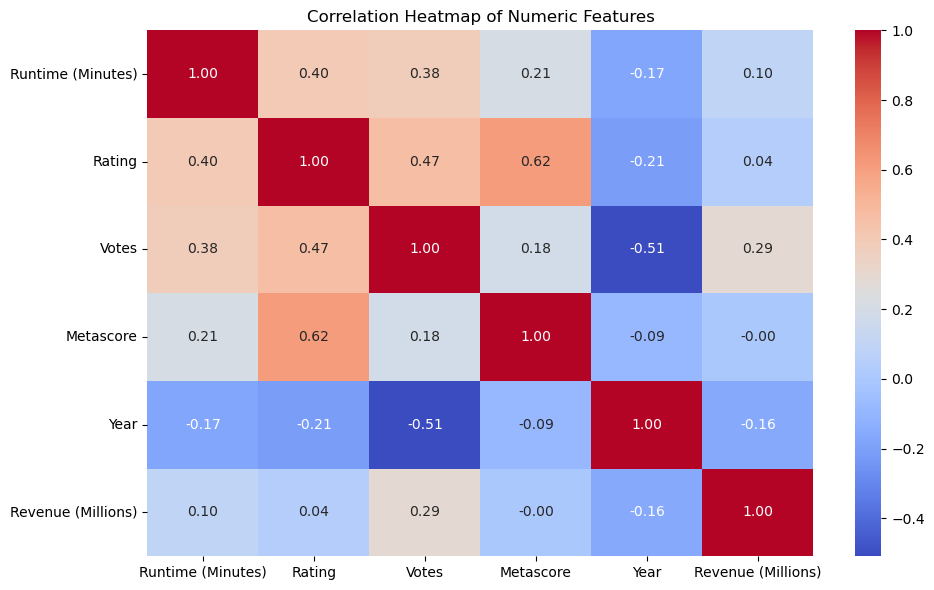

In [17]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[['Runtime (Minutes)', 'Rating', 'Votes', 'Metascore', 'Year', 'Revenue (Millions)']].corr(), 
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

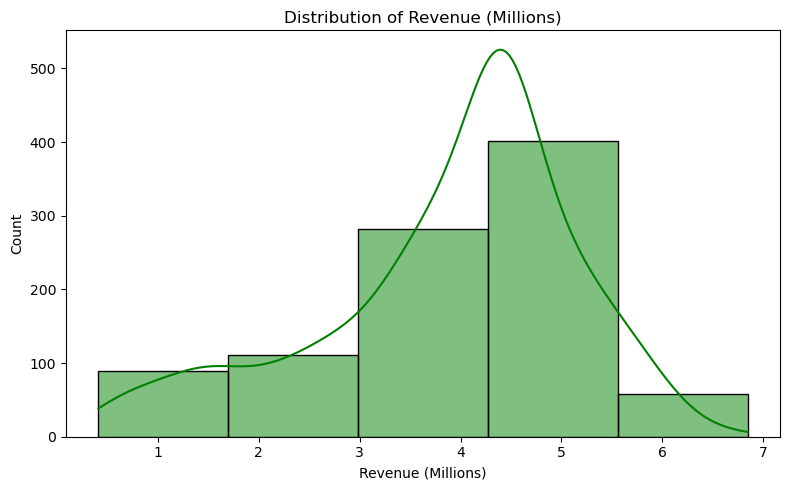

In [18]:
# Distribution of Revenue
plt.figure(figsize=(8, 5))
sns.histplot(df['Revenue (Millions)'], bins=5, kde=True, color='green')
plt.title("Distribution of Revenue (Millions)")
plt.xlabel("Revenue (Millions)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

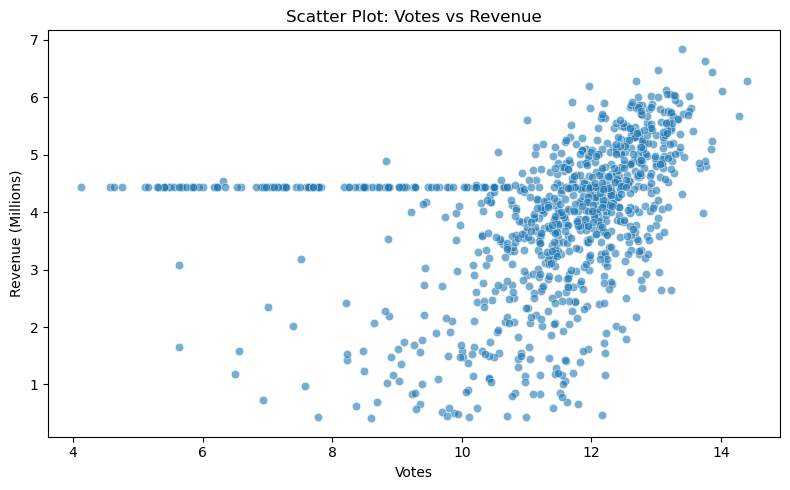

In [19]:
# Scatter Plot – Votes vs Revenue
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Votes', y='Revenue (Millions)', data=df, alpha=0.6)
plt.title("Scatter Plot: Votes vs Revenue")
plt.xlabel("Votes")
plt.ylabel("Revenue (Millions)")
plt.tight_layout()
plt.show()

In [20]:
# Helper function to plot Revenue vs Features
def plot_revenue_vs_feature(df, feature, figsize=(6, 4)):
    plt.figure(figsize=figsize)
    sns.scatterplot(x=feature, y='Revenue (Millions)', data=df, alpha=0.6)
    plt.title(f'Revenue vs {feature}')
    plt.tight_layout()
    plt.show()

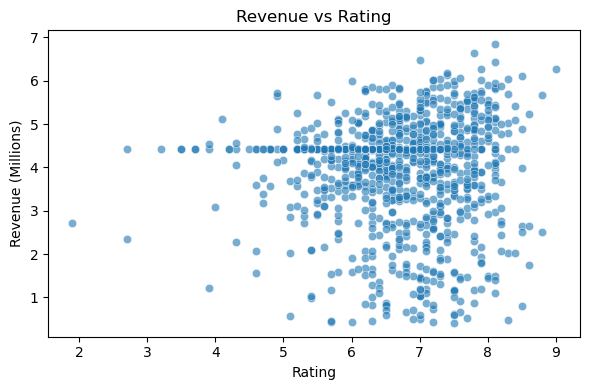

In [21]:
# Revenue vs Influencing Features
plot_revenue_vs_feature(df, 'Rating')

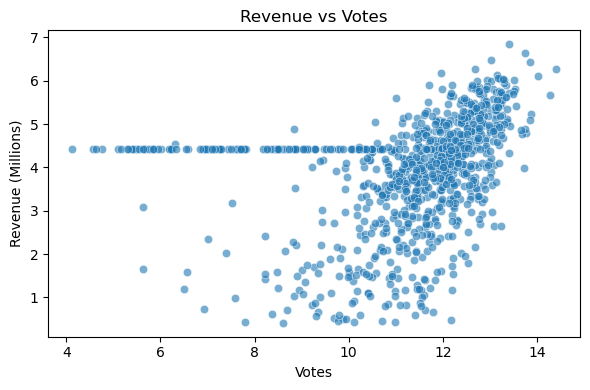

In [22]:
plot_revenue_vs_feature(df, 'Votes')

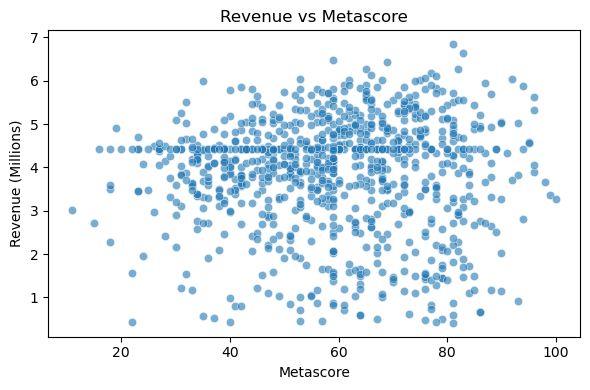

In [23]:
plot_revenue_vs_feature(df, 'Metascore')

In [24]:
# Feature Engineering: Extract main genre
df['MainGenre'] = df['Genre'].apply(lambda x: x.split(',')[0])

In [25]:
# Feature Engineering: Top 10 directors
top_directors = df['Director'].value_counts().nlargest(10).index
df['TopDirector'] = df['Director'].apply(lambda x: x if x in top_directors else 'Other')

In [26]:
# Feature Engineering: Top 10 actors (first actor in list)
df['LeadActor'] = df['Actors'].apply(lambda x: x.split(',')[0])
top_actors = df['LeadActor'].value_counts().nlargest(10).index
df['TopActor'] = df['LeadActor'].apply(lambda x: x if x in top_actors else 'Other')

In [27]:
# Select features
features = ['Runtime (Minutes)', 'Rating', 'Votes', 'Metascore', 'Year',
            'MainGenre', 'TopDirector', 'TopActor']

In [28]:
X = df[features]
y = df['Revenue (Millions)']

In [29]:
# Categorical & numerical features
categorical = ['MainGenre', 'TopDirector', 'TopActor']
numerical = ['Runtime (Minutes)', 'Rating', 'Votes', 'Metascore', 'Year']

In [30]:
# Preprocessing and modeling pipeline
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
], remainder='passthrough')

In [31]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear Regression

In [32]:
model_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [33]:
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

In [34]:
print("MAE:", mean_absolute_error(y_test, y_pred_lr))

MAE: 0.9172058613739386


In [35]:
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))

RMSE: 1.1117888276370715


In [36]:
print("R2 Score:", r2_score(y_test, y_pred_lr))

R2 Score: 0.1195575698189617


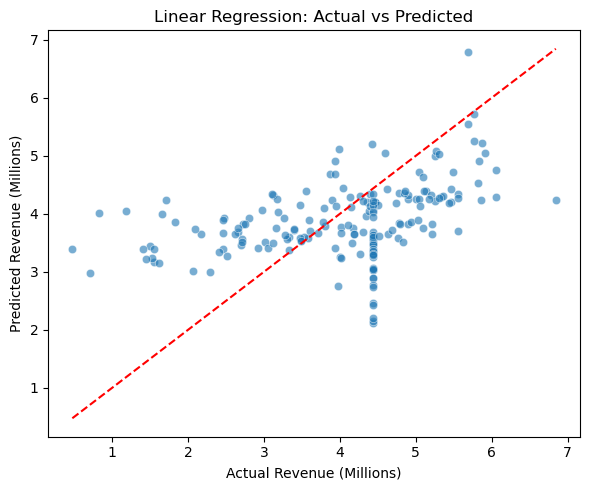

In [37]:
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Revenue (Millions)")
plt.ylabel("Predicted Revenue (Millions)")
plt.title("Linear Regression: Actual vs Predicted")
plt.tight_layout()
plt.show()

In [38]:
# Function to plot residuals
def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title(f"{title} - Residuals Distribution")
    plt.xlabel("Residuals")
    plt.tight_layout()
    plt.show()

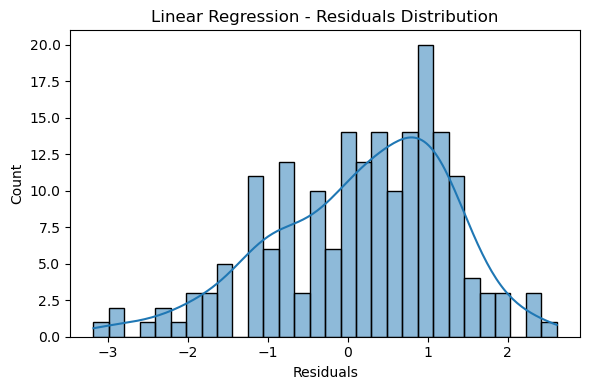

In [39]:
plot_residuals(y_test, y_pred_lr, "Linear Regression")

## Decision Tree Regressor

In [40]:
model_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

In [41]:
model_dt.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['MainGenre', 'TopDirector',
                                                   'TopActor'])])),
                ('model', DecisionTreeRegressor(random_state=42))])

In [42]:
y_pred_dt = model_dt.predict(X_test)

In [43]:
print("MAE:", mean_absolute_error(y_test, y_pred_dt))

MAE: 1.0427334258148506


In [44]:
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_dt)))

RMSE: 1.445578395699722


In [45]:
print("R2 Score:", r2_score(y_test, y_pred_dt))

R2 Score: -0.4884685091751293


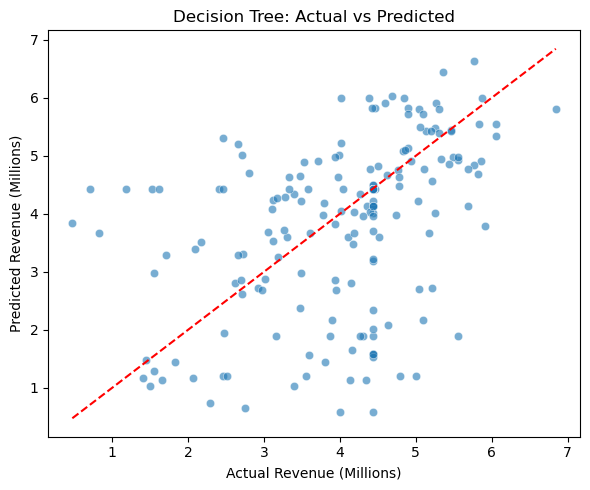

In [46]:
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_test, y=y_pred_dt, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Revenue (Millions)")
plt.ylabel("Predicted Revenue (Millions)")
plt.title("Decision Tree: Actual vs Predicted")
plt.tight_layout()
plt.show()

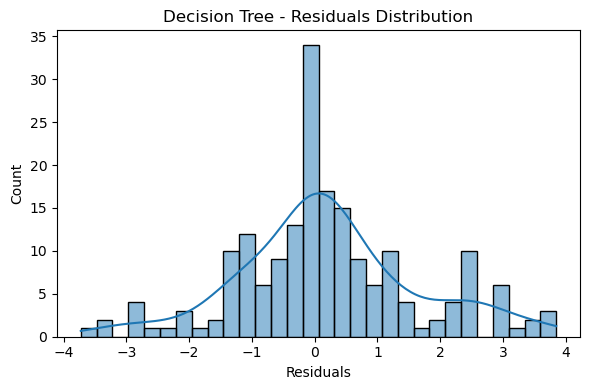

In [47]:
plot_residuals(y_test, y_pred_dt, "Decision Tree")

## Random Forest Regressor

In [48]:
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

In [49]:
model_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['MainGenre', 'TopDirector',
                                                   'TopActor'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [50]:
y_pred_rf = model_rf.predict(X_test)

In [51]:
print("MAE:", mean_absolute_error(y_test, y_pred_rf))

MAE: 0.7068888511554697


In [52]:
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

RMSE: 0.9079012490681777


In [53]:
print("R2 Score:", r2_score(y_test, y_pred_rf))

R2 Score: 0.41287093501710026


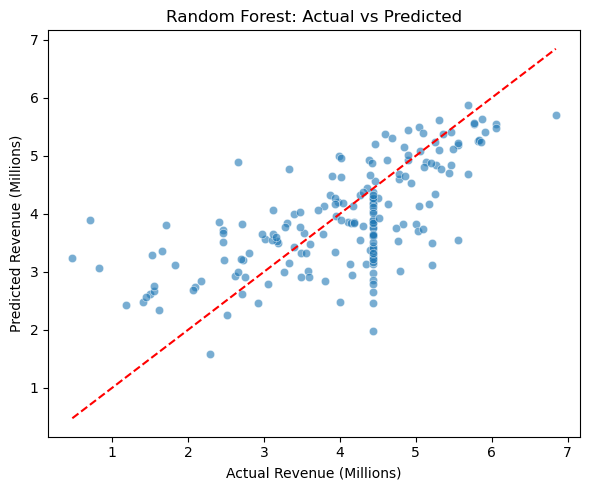

In [54]:
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Revenue (Millions)")
plt.ylabel("Predicted Revenue (Millions)")
plt.title("Random Forest: Actual vs Predicted")
plt.tight_layout()
plt.show()

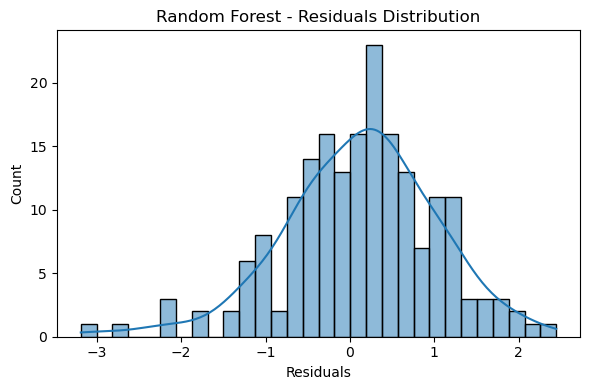

In [55]:
plot_residuals(y_test, y_pred_rf, "Random Forest")

## XGBoost Regressor

In [56]:
model_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42, objective='reg:squarederror'))
])

In [57]:
model_xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['MainGenre', 'TopDirector',
                                                   'TopActor'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              e...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=4, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [58]:
y_pred_xgb = model_xgb.predict(X_test)

In [59]:
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))

MAE: 0.6845581176435775


In [60]:
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))

RMSE: 0.8987169029774342


In [61]:
print("R2 Score:", r2_score(y_test, y_pred_xgb))

R2 Score: 0.42468966914910555


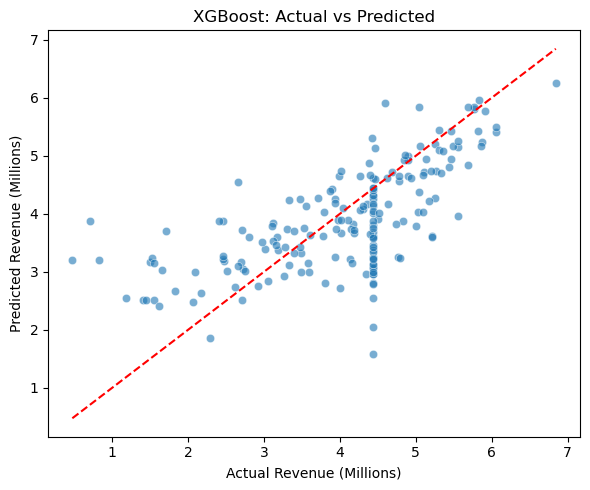

In [62]:
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Revenue (Millions)")
plt.ylabel("Predicted Revenue (Millions)")
plt.title("XGBoost: Actual vs Predicted")
plt.tight_layout()
plt.show()

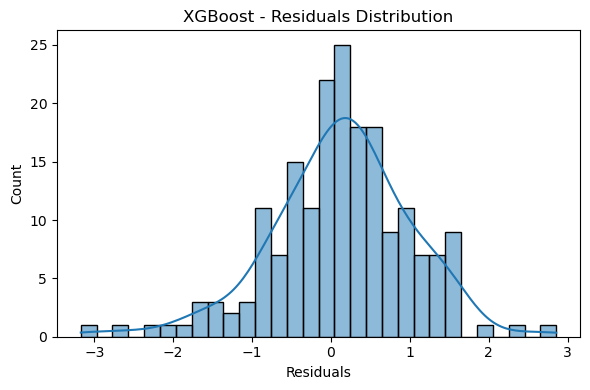

In [63]:
plot_residuals(y_test, y_pred_xgb, "XGBoost")